In [2]:
!pip uninstall -y diffusers transformers huggingface_hub accelerate numpy || true
!pip install -U \
  "numpy==1.26.4" \
  "transformers==4.40.2" \
  "diffusers==0.27.2" \
  "huggingface_hub==0.25.2" \
  "accelerate==0.33.0" \
  "safetensors"


Found existing installation: diffusers 0.27.2
Uninstalling diffusers-0.27.2:
  Successfully uninstalled diffusers-0.27.2
Found existing installation: transformers 4.40.2
Uninstalling transformers-4.40.2:
  Successfully uninstalled transformers-4.40.2
Found existing installation: huggingface-hub 0.25.2
Uninstalling huggingface-hub-0.25.2:
  Successfully uninstalled huggingface-hub-0.25.2
Found existing installation: accelerate 0.33.0
Uninstalling accelerate-0.33.0:
  Successfully uninstalled accelerate-0.33.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
  Using cached diffusers-0.27.2-py3-none-any.whl.metadata (18 kB)
  Using cached huggingface_hub-0.25.2-py3-none-any.whl.metadata (13 kB)
  Using cached accelerate-0.33.0-py3-none-any.whl.metadata (18 kB

In [3]:
!pip uninstall -y peft
# (optional) also remove TRL/autotrain if they’re pulling peft in
!pip uninstall -y trl autotrain-advanced


In [4]:
import transformers, diffusers
from transformers import CLIPImageProcessor
from diffusers import StableDiffusionPipeline

print("transformers:", transformers.__version__)
print("diffusers:", diffusers.__version__)


transformers: 4.40.2
diffusers: 0.27.2


In [5]:
import torch, contextlib
from dataclasses import dataclass

def set_global_perf_flags():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")

def to_half_channels_last(module: torch.nn.Module):
    return module.to(dtype=torch.float16, memory_format=torch.channels_last, device="cuda")

def maybe_enable_attention(pipe):
    # Prefer xFormers; fallback to PyTorch SDPA
    try:
        pipe.unet.set_use_memory_efficient_attention_xformers(True)
    except Exception:
        try:
            torch.backends.cuda.enable_flash_sdp(True)
            torch.backends.cuda.enable_mem_efficient_sdp(True)
            torch.backends.cuda.enable_math_sdp(True)
        except Exception:
            pass

@dataclass
class CompileConfig:
    compile_unet: bool = True
    compile_vae: bool  = True
    compile_text_encoder: bool = False
    backend: str = "inductor"
    mode: str = "max-autotune"
    fullgraph: bool = False

def torch_compile_if(model, do_compile, backend="inductor", mode="max-autotune", fullgraph=False):
    if not do_compile:
        return model
    try:
        return torch.compile(model, backend=backend, mode=mode, fullgraph=fullgraph)
    except Exception as e:
        print("[compile] skipping due to:", e)
        return model

@contextlib.contextmanager
def autocast_fp16():
    with torch.cuda.amp.autocast(dtype=torch.float16):
        yield

def prepare_pipeline(pipe, cfg: CompileConfig = CompileConfig()):
    set_global_perf_flags()
    pipe = pipe.to("cuda")
    pipe.safety_checker = None

    # fp16 + channels_last where safe
    to_half_channels_last(pipe.unet)
    try: to_half_channels_last(pipe.vae)
    except: pass
    pipe.text_encoder = pipe.text_encoder.to(device="cuda")  # keep fp32 for stability

    maybe_enable_attention(pipe)

    # compile hot paths
    pipe.unet = torch_compile_if(pipe.unet, cfg.compile_unet, backend=cfg.backend, mode=cfg.mode, fullgraph=cfg.fullgraph)
    try:
        pipe.vae.decode = torch_compile_if(pipe.vae.decode, cfg.compile_vae, backend=cfg.backend, mode=cfg.mode, fullgraph=cfg.fullgraph)
    except: pass
    if cfg.compile_text_encoder:
        pipe.text_encoder = torch_compile_if(pipe.text_encoder, True, backend=cfg.backend, mode=cfg.mode, fullgraph=cfg.fullgraph)

    # diffusers knobs
    try: pipe.enable_vae_tiling()
    except: pass
    try: pipe.enable_attention_slicing("max")
    except: pass
    return pipe, cfg

@torch.inference_mode()
def generate(pipe, prompt, height=512, width=512, steps=30, guidance=7.5, seed=1234):
    # Make any code that expects this flag happy
    pipe.do_classifier_free_guidance = guidance is not None and guidance > 1.0

    # Reproducible RNG on the same device as the pipe
    g = None
    if seed is not None:
        g = torch.Generator(device=str(pipe.device)).manual_seed(int(seed))

    with autocast_fp16():
        out = pipe(
            prompt=prompt,
            height=height,
            width=width,
            num_inference_steps=steps,
            guidance_scale=guidance,
            generator=g,
        )
    return out.images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[BASELINE] 1.302 s/img | VRAM 2.82 GB


  0%|          | 0/30 [00:00<?, ?it/s]

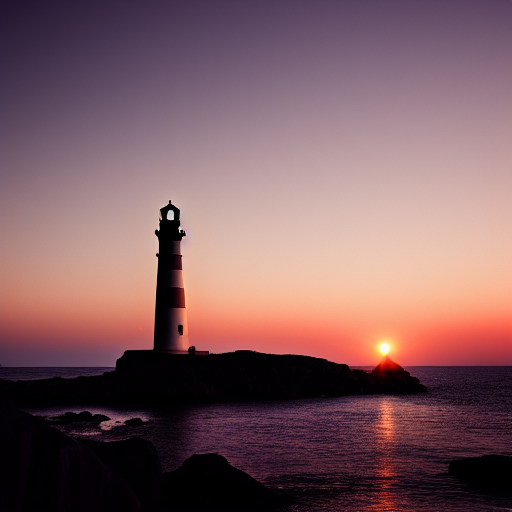

In [7]:
import time, torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from IPython.display import display

assert torch.cuda.is_available(), "CUDA GPU required for float16."
device = "cuda"
dtype  = torch.float16

# Load vanilla SD 1.5
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=dtype,
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)
pipe.safety_checker = None           # disable NSFW checker (optional)
# pipe.enable_attention_slicing()      # helps VRAM on small GPUs

# Simple generator function
@torch.inference_mode()
def generate(pipe, prompt, height, width, steps, guidance, seed=None):
    g = None
    if seed is not None:
        g = torch.Generator(device=device).manual_seed(int(seed))
    out = pipe(
        prompt=prompt,
        height=height,
        width=width,
        num_inference_steps=steps,
        guidance_scale=guidance,
        generator=g,
    )
    return out.images[0]

prompt = "a lighthouse at sunset, cinematic lighting, 35mm, detailed"
height, width, num_steps, guidance = 512, 512, 30, 7.5
inputs = dict(prompt=prompt, height=height, width=width,
              steps=num_steps, guidance=guidance)

# Warmup
for _ in range(2):
    _ = generate(pipe, **inputs)

torch.cuda.reset_peak_memory_stats()
N = 4
t0 = time.time()
for _ in range(N):
    _ = generate(pipe, **inputs)
t1 = time.time()
base_s  = (t1 - t0) / N
base_vr = torch.cuda.max_memory_allocated() / 1e9
print(f"[BASELINE] {base_s:.3f} s/img | VRAM {base_vr:.2f} GB")

# Show a sample
img = generate(pipe, **inputs, seed=123)
display(img)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[SOURCE-ACCEL] 0.552 s/img | VRAM 4.80 GB (compiled)
[SPEEDUP]      2.33x


  0%|          | 0/30 [00:00<?, ?it/s]

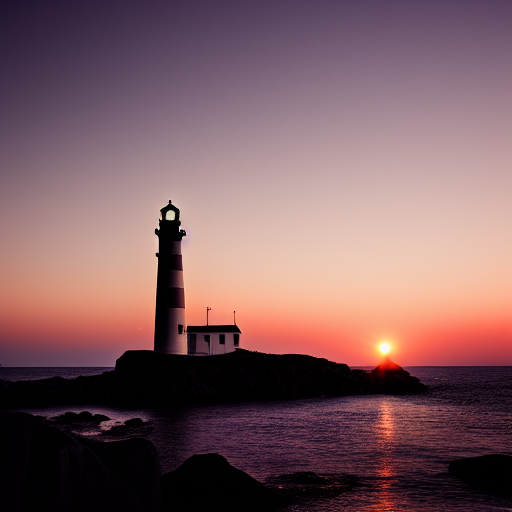

In [36]:
# Optional acceleration: compile UNet and VAE with torch.compile
pipe_fast = pipe
compiled_ok = False
if hasattr(torch, "compile"):
    try:
        pipe_fast.unet = torch.compile(pipe_fast.unet, mode="max-autotune", fullgraph=False)
        pipe_fast.vae  = torch.compile(pipe_fast.vae,  mode="max-autotune", fullgraph=False)
        compiled_ok = True
    except Exception as e:
        print("[compile] skipping –", e)

# Warmup
for _ in range(3):
    _ = generate(pipe_fast, **inputs)

torch.cuda.reset_peak_memory_stats()
t0 = time.time()
for _ in range(N):
    _ = generate(pipe_fast, **inputs)
t1 = time.time()
fast_s  = (t1 - t0) / N
fast_vr = torch.cuda.max_memory_allocated() / 1e9

print(f"[SOURCE-ACCEL] {fast_s:.3f} s/img | VRAM {fast_vr:.2f} GB"
      + (" (compiled)" if compiled_ok else " (uncompiled)"))
print(f"[SPEEDUP]      {base_s/fast_s:.2f}x")

# Show a sample
img = generate(pipe_fast, **inputs, seed=123)
display(img)


  0%|          | 0/30 [00:00<?, ?it/s]

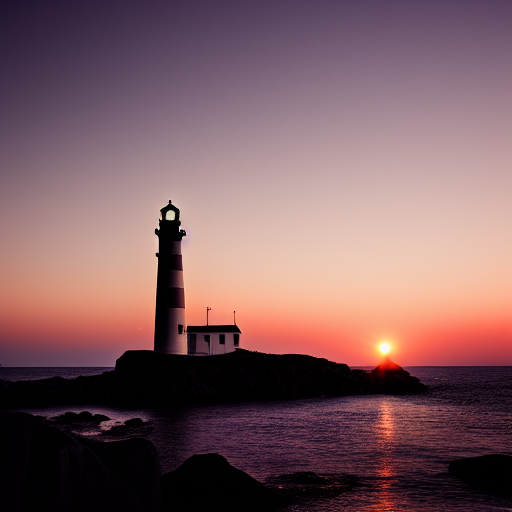

In [29]:

# Show a sample
img = generate(pipe, **inputs, seed=123)
display(img)

In [ ]:
# Sketch: capture a single UNet forward using static buffers
import torch

class GraphUNet(torch.nn.Module):
    def __init__(self, unet, sample_shape, cond_emb_shape, timestep_shape):
        super().__init__()
        self.unet = unet
        self.g = torch.cuda.CUDAGraph()
        self.static_sample = torch.zeros(sample_shape, device="cuda", dtype=torch.float16)
        self.static_emb    = torch.zeros(cond_emb_shape, device="cuda", dtype=torch.float16)
        self.static_t      = torch.zeros(timestep_shape, device="cuda", dtype=torch.float16)
        self.static_out    = None
        # warm run in a stream, then capture
        torch.cuda.synchronize()
        stream = torch.cuda.Stream()
        with torch.cuda.stream(stream), torch.cuda.amp.autocast(dtype=torch.float16):
            self.static_out = self.unet(self.static_sample, self.static_t, self.static_emb).sample
        stream.synchronize()
        torch.cuda.synchronize()
        with torch.cuda.graph(self.g), torch.cuda.amp.autocast(dtype=torch.float16):
            self.static_out = self.unet(self.static_sample, self.static_t, self.static_emb).sample

    def forward(self, sample, t, emb):
        # copy into static buffers, then replay
        self.static_sample.copy_(sample)
        self.static_t.copy_(t)
        self.static_emb.copy_(emb)
        self.g.replay()
        return self.static_out

# Usage idea:
# graph_unet = GraphUNet(pipe_fast.unet, sample_shape=(1,4,64,64), cond_emb_shape=(1,77,1024_or_2048), timestep_shape=(1,))
# and replace pipe_fast.unet with graph_unet in a custom sampler loop.
print("CUDA graph stub defined (for later custom sampler integration).")


CUDA graph stub defined (for later custom sampler integration).


## Tiny VAE

The config attributes {'shift_factor': 0.0, 'upsample_fn': 'nearest'} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[SOURCE-ACCEL] 1.245 s/img | VRAM 2.18 GB (compiled)
[SPEEDUP]      1.05x


  0%|          | 0/30 [00:00<?, ?it/s]

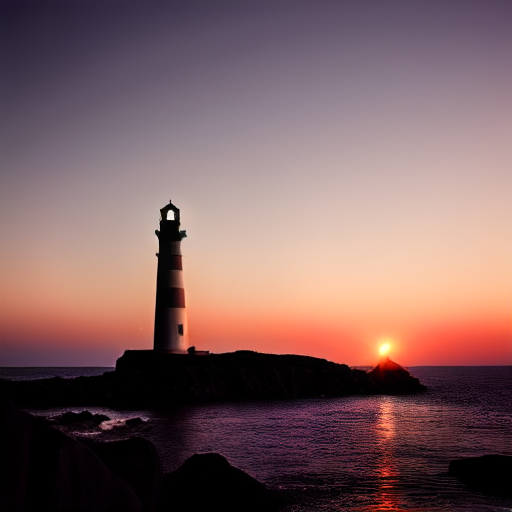

In [9]:
from diffusers import AutoencoderTiny
pipe_fast = pipe
pipe_fast.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float16).to(device)

# Warmup
for _ in range(3):
    _ = generate(pipe_fast, **inputs)

torch.cuda.reset_peak_memory_stats()
t0 = time.time()
for _ in range(N):
    _ = generate(pipe_fast, **inputs)
t1 = time.time()
fast_s  = (t1 - t0) / N
fast_vr = torch.cuda.max_memory_allocated() / 1e9

print(f"[SOURCE-ACCEL] {fast_s:.3f} s/img | VRAM {fast_vr:.2f} GB"
      + (" (compiled)"))
print(f"[SPEEDUP]      {base_s/fast_s:.2f}x")

img = generate(pipe_fast, **inputs, seed=123)
display(img)

The config attributes {'shift_factor': 0.0, 'upsample_fn': 'nearest'} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[SOURCE-ACCEL] 0.516 s/img | VRAM 2.18 GB (compiled)
[SPEEDUP]      2.52x


  0%|          | 0/30 [00:00<?, ?it/s]

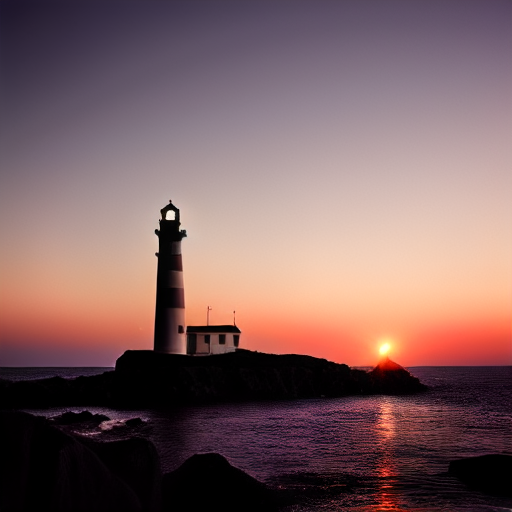

In [10]:
# Optional acceleration: compile UNet and VAE with torch.compile
pipe_fast = pipe
compiled_ok = False
if hasattr(torch, "compile"):
    try:
        pipe_fast.unet = torch.compile(pipe_fast.unet, mode="max-autotune", fullgraph=False)
        pipe_fast.vae  = torch.compile(pipe_fast.vae,  mode="max-autotune", fullgraph=False)
        compiled_ok = True
    except Exception as e:
        print("[compile] skipping –", e)
pipe_fast.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float16).to(device)
# Warmup
for _ in range(3):
    _ = generate(pipe_fast, **inputs)

torch.cuda.reset_peak_memory_stats()
t0 = time.time()
for _ in range(N):
    _ = generate(pipe_fast, **inputs)
t1 = time.time()
fast_s  = (t1 - t0) / N
fast_vr = torch.cuda.max_memory_allocated() / 1e9

print(f"[SOURCE-ACCEL] {fast_s:.3f} s/img | VRAM {fast_vr:.2f} GB"
      + (" (compiled)" if compiled_ok else " (uncompiled)"))
print(f"[SPEEDUP]      {base_s/fast_s:.2f}x")

# Show a sample
img = generate(pipe_fast, **inputs, seed=123)
display(img)


# Benchmarking variants

In [13]:
import time, contextlib
from dataclasses import dataclass

import torch
from diffusers import (
    StableDiffusionPipeline,
    EulerAncestralDiscreteScheduler,
)

# Optional extras – may not exist in older diffusers, so we guard them.
try:
    from diffusers import DPMSolverMultistepScheduler, AutoencoderTiny
except Exception:
    DPMSolverMultistepScheduler = None
    AutoencoderTiny = None

device = "cuda"

# ---------- global perf flags ----------

def set_global_perf_flags():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")

# ---------- dtype / memory helpers ----------

def to_half_channels_last(module: torch.nn.Module):
    return module.to(dtype=torch.float16,
                     memory_format=torch.channels_last,
                     device=device)

def maybe_enable_attention(pipe):
    """
    Try memory-efficient SDPA; fall back if not available.
    """
    # prefer PyTorch SDPA toggles
    try:
        torch.backends.cuda.enable_flash_sdp(True)
        torch.backends.cuda.enable_mem_efficient_sdp(True)
        torch.backends.cuda.enable_math_sdp(True)
        print("[perf] enabled PyTorch SDPA (flash / mem-efficient / math)")
    except Exception as e:
        print("[perf] SDPA not available:", e)

@dataclass
class CompileConfig:
    compile_unet: bool = True
    compile_vae: bool  = True
    compile_text_encoder: bool = False
    backend: str = "inductor"
    mode: str = "max-autotune"
    fullgraph: bool = False

def torch_compile_if(model, do_compile, backend="inductor", mode="max-autotune", fullgraph=False):
    if not do_compile or not hasattr(torch, "compile"):
        return model
    try:
        model = torch.compile(model, backend=backend, mode=mode, fullgraph=fullgraph)
        print(f"[compile] compiled {model.__class__.__name__}")
    except Exception as e:
        print("[compile] skipping due to:", e)
    return model

@contextlib.contextmanager
def autocast_fp16():
    with torch.cuda.amp.autocast(dtype=torch.float16):
        yield

# ---------- pipeline builder ----------

def build_pipe(
    model_id: str = "runwayml/stable-diffusion-v1-5",
    scheduler_type: str = "euler_a",
    use_tiny_vae: bool = False,
    compile_cfg: CompileConfig = CompileConfig(),
):
    set_global_perf_flags()

    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
    )

    # scheduler
    if scheduler_type == "euler_a":
        pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    elif scheduler_type == "dpmpp_2m":
        if DPMSolverMultistepScheduler is None:
            raise RuntimeError("DPMSolverMultistepScheduler not available in this diffusers version.")
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    else:
        raise ValueError(f"Unknown scheduler_type: {scheduler_type}")

    # tiny VAE (TAESD)
    if use_tiny_vae:
        if AutoencoderTiny is None:
            raise RuntimeError("AutoencoderTiny not available; cannot use TAESD.")
        print("[vae] using TAESD tiny autoencoder")
        tiny_vae = AutoencoderTiny.from_pretrained(
            "madebyollin/taesd",
            torch_dtype=torch.float16,
        )
        pipe.vae = tiny_vae

    # disable safety checker for speed
    pipe.safety_checker = None

    # move to GPU
    pipe = pipe.to(device)

    # fp16 + channels_last where safe
    to_half_channels_last(pipe.unet)
    try:
        to_half_channels_last(pipe.vae)
    except Exception:
        pass

    # keep text encoder fp32 but on GPU (for stability)
    pipe.text_encoder = pipe.text_encoder.to(device=device)

    maybe_enable_attention(pipe)

    # compile hot paths
    pipe.unet = torch_compile_if(
        pipe.unet,
        compile_cfg.compile_unet,
        backend=compile_cfg.backend,
        mode=compile_cfg.mode,
        fullgraph=compile_cfg.fullgraph,
    )

    if compile_cfg.compile_vae:
        pipe.vae = torch_compile_if(
            pipe.vae,
            True,
            backend=compile_cfg.backend,
            mode=compile_cfg.mode,
            fullgraph=False,
        )

    if compile_cfg.compile_text_encoder:
        pipe.text_encoder = torch_compile_if(
            pipe.text_encoder,
            True,
            backend=compile_cfg.backend,
            mode=compile_cfg.mode,
            fullgraph=False,
        )

    return pipe


In [14]:
# ---------- dynamic CFG callback (for SD 1.5) ----------

def make_dynamic_cfg_callback(cutoff_ratio: float = 0.4):
    """
    Returns a callback that disables CFG after cutoff_ratio of timesteps.
    Matches the pattern in the diffusers docs for SD 1.5.
    """
    def callback(pipe, step_index, timestep, callback_kwargs):
        # pipe.num_timesteps is set by the scheduler when you call the pipeline
        cutoff_step = int(pipe.num_timesteps * cutoff_ratio)
        if step_index == cutoff_step:
            # prompt_embeds: [2 * batch, ..., hidden_dim] -> drop unconditional half
            prompt_embeds = callback_kwargs["prompt_embeds"]
            prompt_embeds = prompt_embeds.chunk(2)[-1]

            pipe._guidance_scale = 0.0  # effectively disable CFG
            callback_kwargs["prompt_embeds"] = prompt_embeds
        return callback_kwargs

    return callback

# ---------- single-image generation ----------

@torch.inference_mode()
def generate(
    pipe,
    prompt: str,
    height: int = 512,
    width: int = 512,
    steps: int = 30,
    guidance: float = 7.5,
    seed: int = 1234,
    dynamic_cfg_ratio: float | None = None,
):
    g = torch.Generator(device=device).manual_seed(int(seed))

    kwargs = dict(
        prompt=prompt,
        height=height,
        width=width,
        num_inference_steps=steps,
        guidance_scale=guidance,
        generator=g,
    )

    if dynamic_cfg_ratio is not None:
        cfg_cb = make_dynamic_cfg_callback(dynamic_cfg_ratio)
        kwargs["callback_on_step_end"] = cfg_cb
        kwargs["callback_on_step_end_tensor_inputs"] = ["prompt_embeds"]

    with autocast_fp16():
        out = pipe(**kwargs)

    return out.images[0]

# ---------- benchmark ----------

@torch.inference_mode()
def benchmark(
    pipe,
    prompt: str,
    height: int = 512,
    width: int = 512,
    steps: int = 30,
    guidance: float = 7.5,
    seed: int = 1234,
    dynamic_cfg_ratio: float | None = None,
    num_images: int = 4,
):
    # warm-up
    _ = generate(
        pipe,
        prompt=prompt,
        height=height,
        width=width,
        steps=steps,
        guidance=guidance,
        seed=seed,
        dynamic_cfg_ratio=dynamic_cfg_ratio,
    )

    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    t0 = time.perf_counter()

    for i in range(num_images):
        _ = generate(
            pipe,
            prompt=prompt,
            height=height,
            width=width,
            steps=steps,
            guidance=guidance,
            seed=seed + i,
            dynamic_cfg_ratio=dynamic_cfg_ratio,
        )

    torch.cuda.synchronize()
    t1 = time.perf_counter()

    avg_time = (t1 - t0) / num_images
    peak_vram = torch.cuda.max_memory_allocated() / 1e9

    return avg_time, peak_vram


In [15]:
compile_cfg = CompileConfig(
    compile_unet=True,
    compile_vae=True,
    compile_text_encoder=False,
    backend="inductor",
    mode="max-autotune",
    fullgraph=False,
)

prompt = "a lighthouse at sunset, cinematic lighting, 35mm, detailed"
height, width, num_steps, guidance = 512, 512, 30, 7.5

experiments = [
    # name, scheduler, steps, dyn_cfg_ratio, use_tiny_vae
    ("baseline_euler_30",             "euler_a", 30, None,   False),
    ("euler_20",                      "euler_a", 20, None,   False),
    ("euler_20_dyncfg0.4",            "euler_a", 20, 0.4,    False),
    ("dpmpp2m_20",                    "dpmpp_2m", 20, None,  False),
    ("dpmpp2m_20_dyncfg0.4",          "dpmpp_2m", 20, 0.4,   False),
    ("dpmpp2m_20_dyncfg0.4_tinyvae",  "dpmpp_2m", 20, 0.4,   True),
]

results = []

for name, sched, steps, dyn_cfg, tiny_vae in experiments:
    print(f"\n=== {name} ===")
    pipe = build_pipe(
        model_id="runwayml/stable-diffusion-v1-5",
        scheduler_type=sched,
        use_tiny_vae=tiny_vae,
        compile_cfg=compile_cfg,
    )

    avg_t, peak_vram = benchmark(
        pipe,
        prompt=prompt,
        height=height,
        width=width,
        steps=steps,
        guidance=guidance,
        seed=seed,
        dynamic_cfg_ratio=dyn_cfg,
        num_images=4,
    )

    print(f"avg time: {avg_t:.3f} s/image, peak VRAM: {peak_vram:.2f} GB")
    results.append((name, avg_t, peak_vram))



=== baseline_euler_30 ===


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/30 [00:00<?, ?it/s]

Autotune Choices Stats:
{"num_choices": 19, "num_triton_choices": 18, "best_kernel": "triton_mm_268", "best_kernel_desc": "ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4", "best_time": 0.04710400104522705, "best_triton_pos": 0}
AUTOTUNE mm(8192x1280, 1280x320)
strides: [1280, 1], [1, 1280]
dtypes: torch.float16, torch.float16
  triton_mm_268 0.0471 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4
  triton_mm_264 0.0532 ms 88.5% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=128, BLOCK_N=64, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4
  triton_mm_267 0.0553 ms 85.2% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4
  mm 0.0563 ms 83.6% 
 

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

avg time: 0.547 s/image, peak VRAM: 5.13 GB

=== euler_20 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

avg time: 0.395 s/image, peak VRAM: 5.11 GB

=== euler_20_dyncfg0.4 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


  0%|          | 0/20 [00:00<?, ?it/s]

Autotune Choices Stats:
{"num_choices": 19, "num_triton_choices": 18, "best_kernel": "triton_mm_4696", "best_kernel_desc": "ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4", "best_time": 0.02969600073993206, "best_triton_pos": 0}
AUTOTUNE mm(4096x1280, 1280x320)
strides: [1280, 1], [1, 1280]
dtypes: torch.float16, torch.float16
  triton_mm_4696 0.0297 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4
  triton_mm_4697 0.0307 ms 96.7% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=5, num_warps=8
  triton_mm_4695 0.0369 ms 80.6% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4
  triton_mm_4691 0

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

avg time: 0.343 s/image, peak VRAM: 5.11 GB

=== dpmpp2m_20 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


  0%|          | 0/20 [00:00<?, ?it/s]

Autotune Choices Stats:
{"num_choices": 19, "num_triton_choices": 18, "best_kernel": "triton_mm_8792", "best_kernel_desc": "ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4", "best_time": 0.04915200173854828, "best_triton_pos": 0}
AUTOTUNE mm(8192x1280, 1280x320)
strides: [1280, 1], [1, 1280]
dtypes: torch.float16, torch.float16
  triton_mm_8792 0.0492 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=128, BLOCK_N=128, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4
  triton_mm_8788 0.0543 ms 90.6% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=128, BLOCK_N=64, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=4
  mm 0.0563 ms 87.3% 
  triton_mm_8783 0.0563 ms 87.3% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=64, BLOCK_M=64, BLOCK_N=64, EVEN_K=True, GROUP_M=8, USE_FAST_ACCUM=False, num_stages=3, num_warps=8

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

avg time: 0.402 s/image, peak VRAM: 5.11 GB

=== dpmpp2m_20_dyncfg0.4 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

avg time: 0.347 s/image, peak VRAM: 5.11 GB

=== dpmpp2m_20_dyncfg0.4_tinyvae ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'shift_factor': 0.0, 'upsample_fn': 'nearest'} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


[vae] using TAESD tiny autoencoder
[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

avg time: 0.297 s/image, peak VRAM: 4.13 GB


In [17]:
# Pretty-print the results list: (name, avg_time, peak_vram)

print(f"{'Variant':<35} {'Time (s/img)':>12} {'VRAM (GB)':>10}")
print("-" * 60)

for name, avg_t, vram in results:
    print(f"{name:<35} {avg_t:>12.3f} {vram:>10.2f}")


Variant                             Time (s/img)  VRAM (GB)
------------------------------------------------------------
baseline_euler_30                          0.547       5.13
euler_20                                   0.395       5.11
euler_20_dyncfg0.4                         0.343       5.11
dpmpp2m_20                                 0.402       5.11
dpmpp2m_20_dyncfg0.4                       0.347       5.11
dpmpp2m_20_dyncfg0.4_tinyvae               0.297       4.13



=== baseline_euler_30 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/30 [00:00<?, ?it/s]

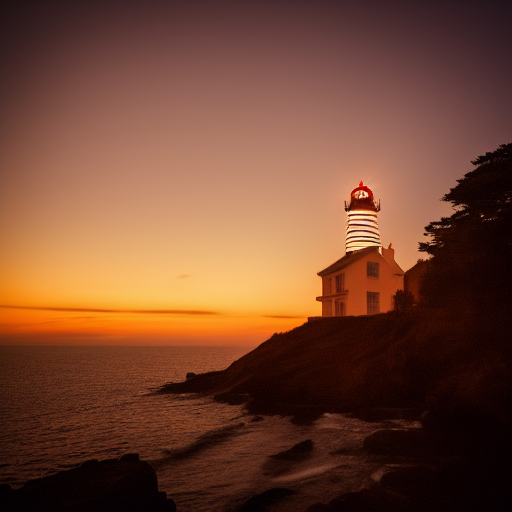


=== euler_20 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

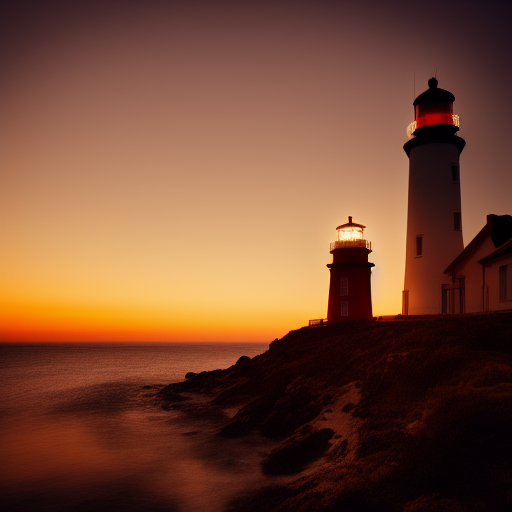


=== euler_20_dyncfg0.4 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

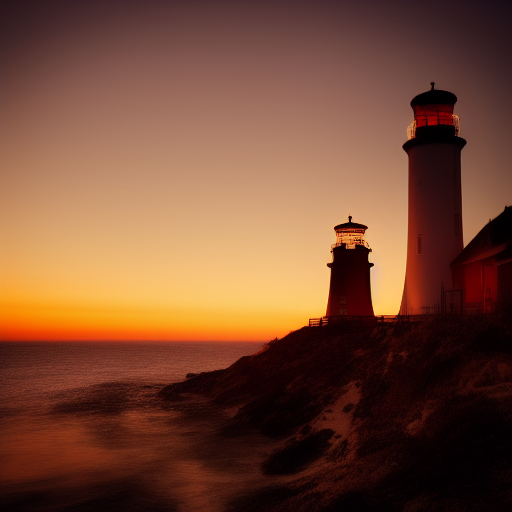


=== dpmpp2m_20 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

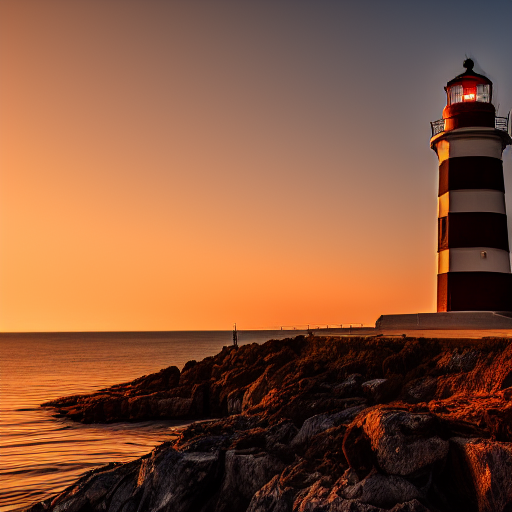


=== dpmpp2m_20_dyncfg0.4 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

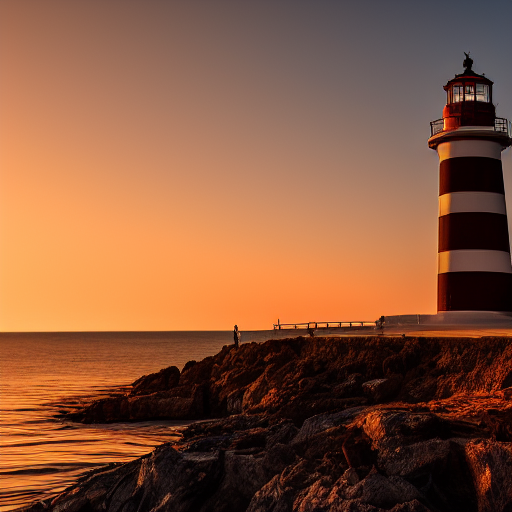


=== dpmpp2m_20_dyncfg0.4_tinyvae ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'shift_factor': 0.0, 'upsample_fn': 'nearest'} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


[vae] using TAESD tiny autoencoder
[perf] enabled PyTorch SDPA (flash / mem-efficient / math)
[compile] compiled OptimizedModule
[compile] compiled OptimizedModule


/tmp/ipython-input-56390001.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


  0%|          | 0/20 [00:00<?, ?it/s]

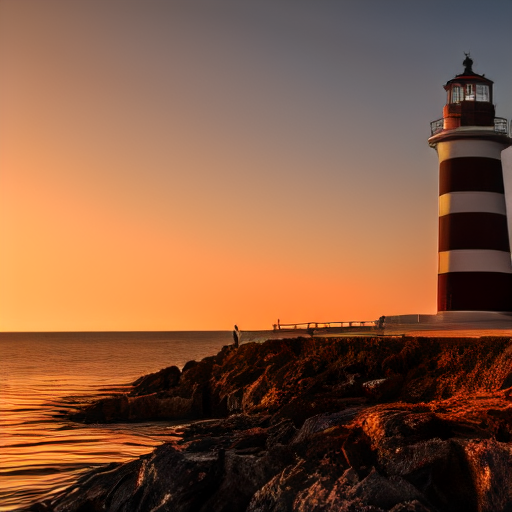

In [20]:
from IPython.display import display

def visualize_experiments(
    experiments,
    prompt,
    height=512,
    width=512,
    guidance=7.5,
    base_seed=1234,
):
    imgs = {}

    for name, sched, steps, dyn_cfg, tiny_vae in experiments:
        print(f"\n=== {name} ===")
        pipe = build_pipe(
            model_id="runwayml/stable-diffusion-v1-5",
            scheduler_type=sched,
            use_tiny_vae=tiny_vae,
            compile_cfg=compile_cfg,
        )

        img = generate(
            pipe,
            prompt=prompt,
            height=height,
            width=width,
            steps=steps,
            guidance=guidance,
            seed=base_seed,
            dynamic_cfg_ratio=dyn_cfg,
        )

        imgs[name] = img
        display(img)

    return imgs

# Call this once to generate + show everything
prompt = "a lighthouse at sunset, cinematic lighting, 35mm, detailed"
height, width, num_steps, guidance = 512, 512, 30, 7.5
all_images = visualize_experiments(
    experiments=experiments,
    prompt=prompt,
    height=height,
    width=width,
    guidance=guidance,
    base_seed=seed,
)


In [21]:
import pandas as pd

# --- raw measurements you gave ---
baseline_time = 1.302  # s/img
baseline_vram = 2.82   # GB

runs = [
    # name, human_label, time_s_per_img, vram_GB
    ("baseline",
     "Baseline (uncompiled, big VAE)",
     1.302, 2.82),

    ("compiled_unet_vae",
     "Compiled UNet + VAE",
     0.552, 4.80),

    ("tiny_vae",
     "Tiny VAE only (TAESD)",
     1.245, 2.18),

    ("compiled_plus_tiny",
     "Compiled UNet + VAE + Tiny VAE",
     0.516, 2.18),
]

rows = []
for key, label, t, v in runs:
    speedup = baseline_time / t
    vram_delta = v - baseline_vram             # + = more VRAM, - = less
    vram_saving = baseline_vram - v            # + = less VRAM than baseline
    vram_saving_pct = (vram_saving / baseline_vram) * 100

    rows.append({
        "id": key,
        "config": label,
        "time_s_per_img": t,
        "peak_vram_GB": v,
        "speedup_vs_baseline": speedup,
        "vram_saving_GB": vram_saving,
        "vram_saving_pct": vram_saving_pct,
    })

df = pd.DataFrame(rows)

# Pretty print
with pd.option_context("display.float_format", "{:.3f}".format):
    display(df.sort_values("time_s_per_img"))

print("\nCompact text table:")
print(f"{'Config':<32} {'t (s/img)':>9} {'VRAM (GB)':>9} {'Speedup':>9} {'ΔVRAM (GB)':>11} {'VRAM Δ%':>9}")
print("-" * 80)
for r in rows:
    print(f"{r['id']:<32} "
          f"{r['time_s_per_img']:>9.3f} "
          f"{r['peak_vram_GB']:>9.2f} "
          f"{r['speedup_vs_baseline']:>9.2f}x "
          f"{r['vram_saving_GB']:>11.2f} "
          f"{r['vram_saving_pct']:>8.1f}%")


id                          config  time_s_per_img  \
3  compiled_plus_tiny  Compiled UNet + VAE + Tiny VAE           0.516   
1   compiled_unet_vae             Compiled UNet + VAE           0.552   
2            tiny_vae           Tiny VAE only (TAESD)           1.245   
0            baseline  Baseline (uncompiled, big VAE)           1.302   

   peak_vram_GB  speedup_vs_baseline  vram_saving_GB  vram_saving_pct  
3         2.180                2.523           0.640           22.695  
1         4.800                2.359          -1.980          -70.213  
2         2.180                1.046           0.640           22.695  
0         2.820                1.000           0.000            0.000


Compact text table:
Config                           t (s/img) VRAM (GB)   Speedup  ΔVRAM (GB)   VRAM Δ%
--------------------------------------------------------------------------------
baseline                             1.302      2.82      1.00x        0.00      0.0%
compiled_unet_vae                    0.552      4.80      2.36x       -1.98    -70.2%
tiny_vae                             1.245      2.18      1.05x        0.64     22.7%
compiled_plus_tiny                   0.516      2.18      2.52x        0.64     22.7%


In [22]:
import pandas as pd

# ---- 1) Baseline numbers (from your message) ----
baseline_time = 1.302  # s/img
baseline_vram = 2.82   # GB

# ---- 2) Extra "Source-Accel" measurements you reported ----
# [BASELINE] 1.302 s/img | VRAM 2.82 GB
# [SOURCE-ACCEL] 0.552 s/img | VRAM 4.80 GB (compiled unet + vae)
# [SOURCE-ACCEL] 1.245 s/img | VRAM 2.18 GB (tiny vae)
# [SOURCE-ACCEL] 0.516 s/img | VRAM 2.18 GB (compiled + tiny vae)

extra_runs = [
    ("manual_baseline",      "Manual Baseline",                    1.302, 2.82),
    ("compiled_unet_vae",    "Compiled UNet + VAE",                0.552, 4.80),
    ("tiny_vae_only",        "Tiny VAE only (TAESD)",              1.245, 2.18),
    ("compiled_plus_tiny",   "Compiled UNet + VAE + Tiny VAE",     0.516, 2.18),
]

# ---- 3) Build a unified rows list from `results` + extra_runs ----
rows = []

# a) from your benchmark `results` variable
for name, avg_t, peak_vram in results:
    rows.append({
        "id": name,
        "config": f"exp::{name}",
        "source": "results",          # comes from automatic sweep
        "time_s_per_image": avg_t,
        "peak_vram_GB": peak_vram,
    })

# b) from your manual Source-Accel numbers
for key, label, t, v in extra_runs:
    rows.append({
        "id": key,
        "config": label,
        "source": "source_accel",     # comes from your manual measurements
        "time_s_per_image": t,
        "peak_vram_GB": v,
    })

# ---- 4) Add speedup + VRAM savings vs baseline ----
for r in rows:
    t = r["time_s_per_image"]
    v = r["peak_vram_GB"]
    speedup = baseline_time / t
    vram_saving = baseline_vram - v
    vram_saving_pct = (vram_saving / baseline_vram) * 100

    r["speedup_vs_baseline"] = speedup
    r["vram_saving_GB"] = vram_saving
    r["vram_saving_pct"] = vram_saving_pct

df_all = pd.DataFrame(rows)

# ---- 5) Pretty display in notebook ----
with pd.option_context("display.float_format", "{:.3f}".format):
    display(df_all.sort_values(["source", "time_s_per_image"]))

print("\nCompact text table:")
print(f"{'id':<28} {'src':<12} {'t (s/img)':>9} {'VRAM (GB)':>9} "
      f"{'Speedup':>9} {'ΔVRAM (GB)':>11} {'VRAM Δ%':>9}")
print("-" * 90)

for r in df_all.sort_values(["source", "time_s_per_image"]).to_dict("records"):
    print(f"{r['id']:<28} {r['source']:<12} "
          f"{r['time_s_per_image']:>9.3f} {r['peak_vram_GB']:>9.2f} "
          f"{r['speedup_vs_baseline']:>9.2f}x {r['vram_saving_GB']:>11.2f} "
          f"{r['vram_saving_pct']:>8.1f}%")


id                             config  \
5  dpmpp2m_20_dyncfg0.4_tinyvae  exp::dpmpp2m_20_dyncfg0.4_tinyvae   
2            euler_20_dyncfg0.4            exp::euler_20_dyncfg0.4   
4          dpmpp2m_20_dyncfg0.4          exp::dpmpp2m_20_dyncfg0.4   
1                      euler_20                      exp::euler_20   
3                    dpmpp2m_20                    exp::dpmpp2m_20   
0             baseline_euler_30             exp::baseline_euler_30   
9            compiled_plus_tiny     Compiled UNet + VAE + Tiny VAE   
7             compiled_unet_vae                Compiled UNet + VAE   
8                 tiny_vae_only              Tiny VAE only (TAESD)   
6               manual_baseline                    Manual Baseline   

         source  time_s_per_image  peak_vram_GB  speedup_vs_baseline  \
5       results             0.297         4.134                4.378   
2       results             0.343         5.114                3.799   
4       results             0.347         5.113                3.756   
1       results             0.395         5.114                3.298   
3       results             0.402         5.111                3.239   
0       results             0.547         5.127                2.379   
9  source_accel             0.516         2.180                2.523   
7  source_accel             0.552         4.800                2.359   
8  source_accel             1.245         2.180                1.046   
6  source_accel             1.302         2.820                1.000   

   vram_saving_GB  vram_saving_pct  
5          -1.314          -46.595  
2          -2.294          -81.363  
4          -2.293          -81.301  
1          -2.294          -81.360  
3          -2.291          -81.227  
0          -2.307          -81.795  
9           0.640           22.695  
7          -1.980          -70.213  
8           0.640           22.695  
6           0.000            0.000


Compact text table:
id                           src          t (s/img) VRAM (GB)   Speedup  ΔVRAM (GB)   VRAM Δ%
------------------------------------------------------------------------------------------
dpmpp2m_20_dyncfg0.4_tinyvae results          0.297      4.13      4.38x       -1.31    -46.6%
euler_20_dyncfg0.4           results          0.343      5.11      3.80x       -2.29    -81.4%
dpmpp2m_20_dyncfg0.4         results          0.347      5.11      3.76x       -2.29    -81.3%
euler_20                     results          0.395      5.11      3.30x       -2.29    -81.4%
dpmpp2m_20                   results          0.402      5.11      3.24x       -2.29    -81.2%
baseline_euler_30            results          0.547      5.13      2.38x       -2.31    -81.8%
compiled_plus_tiny           source_accel     0.516      2.18      2.52x        0.64     22.7%
compiled_unet_vae            source_accel     0.552      4.80      2.36x       -1.98    -70.2%
tiny_vae_only                sourc

# Demo